
# 🧪 SmartRAG — Évaluation RAG (POC Métier) avec **RAGAS** — v8
Axes 0–1 fixes • Corrélation robuste • Dashboard multi‑runs • Parsing `|||` prioritaire • **doc_jaccard**

**Colonnes attendues :**
- Références métier : `question`, `reference_answer`, `sharepoint_document` *(si plusieurs docs → séparés par `|||`)*
- Sorties RAG : `ragas_question`, `ragas_answer`, `ragas_contexts` *(si plusieurs contexts → `|||`)*, `ragas_ground_truth` *(docs cités, `|||`)*

**Métriques RAGAS :** `faithfulness`, `answer_correctness`, `response/answer_relevancy`, `context_precision`, `context_recall`  
**Métriques doc-level (custom) :** `doc_precision`, `doc_recall`, `doc_f1`, **`doc_jaccard`**


**Plus :** doc_precision/recall/F1, diagnostics enrichis, graphiques (axes 0–1 fixes), matrice de corrélation robuste, dashboard **multi‑runs**.

### Métriques RAGAS calculées
1. 🎯 **Faithfulness (Fidélité)** — cohérence factuelle *réponse ↔ contextes*  
2. ✅ **Answer Correctness (Correction)** — *réponse ↔ vérité métier (reference_answer)*  
3. 💬 **Relevancy (Pertinence)** — *réponse ↔ question* (auto-détection `response_relevancy`/`answer_relevancy`)  
4. 🎯 **Context Precision (Précision)** — pertinence des contextes récupérés  
5. 📚 **Context Recall (Rappel)** — complétude des contextes récupérés  

### Analyses additionnelles (POC)
- **Mesures documentaires** (à partir de `sharepoint_document` et `ragas_ground_truth`) : *doc-precision/recall/F1*  
- **Diagnostics détaillés** (tailles, Jaccard coverage, #contexts, etc.)  
- **Visualisations** et **explications** (histos, scatters, corrélations, effets de n_contexts, per-doc)  
- **Recommandations automatiques** & **Plan d’expériences** (préprocessing PDF, embeddings, chunking, recherche hybride, reranking, prompts de génération)


## 0) Installation & vérifications

In [2]:
# 1) Installer
!pip install -U ipywidgets tqdm

# 2) Pas besoin de "jupyter nbextension ..." en JupyterLab (normal que la commande n’existe pas)
# 3) IMPORTANT : redémarre le kernel ici (Kernel > Restart)

# 4) Après redémarrage :
import os, sys, platform, importlib
import ipywidgets as W
from IPython.display import display
try:
    display(W.IntProgress(min=0, max=1, description="widgets OK"))
    from tqdm.notebook import tqdm
    print("tqdm notebook OK ✅")
except Exception as e:
    from tqdm.auto import tqdm
    print("Fallback tqdm auto ⚠️ ->", e)

# (test)
_ = [x for x in tqdm(range(50), desc="Test tqdm (widgets)", leave=False)]

def check_pkg(name):
    try:
        m = importlib.import_module(name)
        return getattr(m, "__version__", "installed")
    except Exception as e:
        return f"not found: {e}"

print("Python:", sys.version.split()[0], "| OS:", platform.platform())
print("ragas:", check_pkg("ragas"))
print("langchain:", check_pkg("langchain"))
print("datasets:", check_pkg("datasets"))
print("pandas:", check_pkg("pandas"))


IntProgress(value=0, description='widgets OK', max=1)

tqdm notebook OK ✅


Test tqdm (widgets):   0%|          | 0/50 [00:00<?, ?it/s]

Python: 3.13.5 | OS: Linux-5.15.153.1-microsoft-standard-WSL2-x86_64-with-glibc2.39
ragas: 0.3.2
langchain: 0.3.27
datasets: 4.0.0
pandas: 2.3.2


Vérifiez que ragas, langchain, datasets, pandas sont listés avec des versions chargées.

Si vous forcez des barres de progression texte, préférez tqdm.auto et TQDM_NOTEBOOK=0.

Toute erreur d’import ici bloquera la suite ; relancez le kernel après installation si nécessaire.

## 1) Configuration — LLM & chemins de fichiers

In [3]:

import os
# LLM pour RAGAS: "openai" | "claude" | "gemini" | "ollama"
RAGAS_LLM_PROVIDER = os.getenv("RAGAS_LLM_PROVIDER", "openai").lower()
OPENAI_MODEL  = os.getenv("OPENAI_MODEL",  "gpt-4o-mini")
CLAUDE_MODEL  = os.getenv("CLAUDE_MODEL",  "claude-3-5-sonnet-20240620")
GEMINI_MODEL  = os.getenv("GEMINI_MODEL",  "gemini-1.5-pro")
OLLAMA_MODEL  = os.getenv("OLLAMA_MODEL",  "llama3.1:8b")

# Clés d'API attendues dans l'environnement
os.environ["OPENAI_API_KEY"]     = "your-openai-api-key"
# os.environ["ANTHROPIC_API_KEY"]  = "..."
# os.environ["GOOGLE_API_KEY"]     = "..."

# Données
DATA_PATH = os.getenv("DATA_PATH", "reference_qa_manuel_template.csv")
# Sorties
OUTPUT_DIR = os.getenv("OUTPUT_DIR", "outputs")
os.makedirs(OUTPUT_DIR, exist_ok=True)
print("Provider:", RAGAS_LLM_PROVIDER)
print("Data path:", DATA_PATH)
print("Output dir:", OUTPUT_DIR)


Provider: openai
Data path: reference_qa_manuel_template.csv
Output dir: outputs


RAGAS_LLM_PROVIDER détermine le wrapper LLM (OpenAI/Claude/Gemini/Ollama).

DATA_PATH pointe vers votre CSV d’évaluation ; OUTPUT_DIR recevra tous les artefacts.

Pensez aux variables d’environnement de vos clés API selon le provider choisi.

## 2) Chargement du CSV & aperçu

In [4]:

import pandas as pd, os
if not os.path.exists(DATA_PATH):
    alt = '../data/reference/reference_qa_manuel_template.csv'
    if os.path.exists(alt):
        DATA_PATH = alt
        print(f"INFO: DATA_PATH introuvable, utilisation de {alt}")
    else:
        raise FileNotFoundError(f"CSV introuvable: {DATA_PATH}")
raw_df = pd.read_csv(DATA_PATH)
print("Shape:", raw_df.shape)
display(raw_df.head(5))
print("Colonnes:", list(raw_df.columns))


INFO: DATA_PATH introuvable, utilisation de ../data/reference/reference_qa_manuel_template.csv
Shape: (12, 8)


,question_id,question,reference_answer,sharepoint_document,ragas_question,ragas_answer,ragas_contexts,ragas_ground_truth
0,QNeo001,Qui est le chef de projet du Projet Néo ?,Marc Dubois est le chef de projet du Projet Néo.,Note de cadrage - Projet Neo.txt,Qui est le chef de projet du Projet Néo ?,Marc Dubois est le chef de projet du Projet Né...,[Document: Note de cadrage - Projet Neo.txt] L...,Note de cadrage - Projet Neo.txt ||| Archive t...
1,QNeo002,Quel est l'objectif principal du Projet Néo ?,Le Projet Néo vise à développer un nouvel algo...,Note de cadrage - Projet Neo.txt,Quel est l'objectif principal du Projet Néo ?,L'objectif du Projet Néo est de développer un ...,[Document: Note de cadrage - Projet Neo.txt] L...,Note de cadrage - Projet Neo.txt
2,QNeo003,Qui est le lead developer assigné au projet ?,Sophie Martin est le lead developer assigné au...,Note de cadrage - Projet Neo.txt,Qui est le lead developer assigné au projet ?,Sophie Martin est désignée comme Lead Develope...,[Document: Note de cadrage - Projet Neo.txt] L...,Note de cadrage - Projet Neo.txt
3,QNeo004,Quelles sont les compétences de David Chen ?,"David Chen possède des compétences en Python, ...",Repertoire equipe - Projet Neo.txt,Quelles sont les compétences de David Chen ?,"David Chen, Data Scientist Principal, maîtrise...",[Document: Repertoire equipe - Projet Neo.txt]...,Repertoire equipe - Projet Neo.txt
4,QNeo005,Qui est le manager de Sophie Martin ?,Marc Dubois est le manager de Sophie Martin.,Repertoire equipe - Projet Neo.txt,Qui est le manager de Sophie Martin ?,Marc Dubois est le manager de Sophie Martin se...,[Document: Repertoire equipe - Projet Neo.txt]...,Repertoire equipe - Projet Neo.txt


Colonnes: ['question_id', 'question', 'reference_answer', 'sharepoint_document', 'ragas_question', 'ragas_answer', 'ragas_contexts', 'ragas_ground_truth']


SyntaxError: invalid character '⇒' (U+21D2) (3676942395.py, line 4)

Shape / Colonnes : contrôlez la présence de
question, reference_answer, sharepoint_document, ragas_question, ragas_answer, ragas_contexts, ragas_ground_truth.

Vérifiez que sharepoint_document, ragas_ground_truth, ragas_contexts utilisent bien ||| pour la multiplicité.

Colonnes vides ⇒ certaines métriques seront NaN (ex. context_recall si contexts ou ground_truth manquent).


## 3) Normalisation → Clés RAGAS & parsing `|||` prioritaire
- Parser de listes **priorise `|||`** puis gère des séparateurs de secours.
- Normalisation **doc_id** avant comparaison (minuscule, espaces, `%20`→ espace, retrait `?query/#fragment`).


In [5]:

import ast, math, re

def to_list_generic(x):
    # 1) priorité au séparateur "|||"
    if isinstance(x, str) and "|||" in x:
        return [p.strip() for p in x.split("|||") if p.strip()]
    # 2) fallback robustes
    if x is None or (isinstance(x, float) and math.isnan(x)): return []
    if isinstance(x, list): return [str(xx).strip() for xx in x if str(xx).strip()]
    if isinstance(x, str):
        s = x.strip()
        if (s.startswith('[') and s.endswith(']')) or (s.startswith('(') and s.endswith(')')):
            try:
                parsed = ast.literal_eval(s)
                if isinstance(parsed, (list, tuple)):
                    return [str(xx).strip() for xx in parsed if str(xx).strip()]
            except Exception: pass
        for sep in ["§§", ";;", "##", "\n", ","]:
            if sep in s: return [p.strip() for p in s.split(sep) if p.strip()]
        return [s] if s else []
    return [str(x).strip()]

def norm_id(s: str) -> str:
    s = (s or "").strip().lower()
    s = s.replace("%20", " ")
    s = re.sub(r"[\?#].*$", "", s)
    s = re.sub(r"\s+", " ", s)
    return s

def norm_list(lst):
    return [norm_id(x) for x in (lst or []) if str(x).strip()]

df = raw_df.copy()

# question: ragas_question sinon question
q_series = df["ragas_question"].fillna(df.get("question","")) if "ragas_question" in df else df.get("question","")

dataset_dict = {
    "question": q_series.astype(str).tolist(),
    "answer": df.get("ragas_answer","").fillna("").astype(str).tolist(),
    "contexts": [to_list_generic(v) for v in df.get("ragas_contexts","").fillna("").tolist()],
    "ground_truth": df.get("reference_answer","").fillna("").astype(str).tolist(),
}

# Documents attendus / cités (séparés par "|||") + normalisation
reference_docs_raw = [to_list_generic(v) for v in df.get("sharepoint_document","").fillna("").tolist()]
cited_docs_raw     = [to_list_generic(v) for v in df.get("ragas_ground_truth","").fillna("").tolist()]
reference_docs = [norm_list(v) for v in reference_docs_raw]
cited_docs     = [norm_list(v) for v in cited_docs_raw]

aux_docs = {
    "reference_docs": reference_docs, "cited_docs": cited_docs,
    "reference_docs_raw": reference_docs_raw, "cited_docs_raw": cited_docs_raw
}

print("Exemple parsing/normalisation :")
if len(reference_docs_raw):
    print(" sharepoint_document (raw) :", reference_docs_raw[0])
    print(" sharepoint_document (norm):", reference_docs[0])
if len(cited_docs_raw):
    print(" ragas_ground_truth (raw)  :", cited_docs_raw[0])
    print(" ragas_ground_truth (norm) :", cited_docs[0])


Exemple parsing/normalisation :
 sharepoint_document (raw) : ['Note de cadrage - Projet Neo.txt']
 sharepoint_document (norm): ['note de cadrage - projet neo.txt']
 ragas_ground_truth (raw)  : ['Note de cadrage - Projet Neo.txt', 'Archive test doc.txt']
 ragas_ground_truth (norm) : ['note de cadrage - projet neo.txt', 'archive test doc.txt']


### Debug parsing & variabilité des métriques doc

In [6]:

import pandas as pd
pd.set_option("display.max_colwidth", 120)
preview = pd.DataFrame({
    "sharepoint_document_RAW": aux_docs["reference_docs_raw"][:5],
    "sharepoint_document_NORM": aux_docs["reference_docs"][:5],
    "ragas_ground_truth_RAW": aux_docs["cited_docs_raw"][:5],
    "ragas_ground_truth_NORM": aux_docs["cited_docs"][:5],
})
display(preview)


,sharepoint_document_RAW,sharepoint_document_NORM,ragas_ground_truth_RAW,ragas_ground_truth_NORM
0,[Note de cadrage - Projet Neo.txt],[note de cadrage - projet neo.txt],"[Note de cadrage - Projet Neo.txt, Archive test doc.txt]","[note de cadrage - projet neo.txt, archive test doc.txt]"
1,[Note de cadrage - Projet Neo.txt],[note de cadrage - projet neo.txt],[Note de cadrage - Projet Neo.txt],[note de cadrage - projet neo.txt]
2,[Note de cadrage - Projet Neo.txt],[note de cadrage - projet neo.txt],[Note de cadrage - Projet Neo.txt],[note de cadrage - projet neo.txt]
3,[Repertoire equipe - Projet Neo.txt],[repertoire equipe - projet neo.txt],[Repertoire equipe - Projet Neo.txt],[repertoire equipe - projet neo.txt]
4,[Repertoire equipe - Projet Neo.txt],[repertoire equipe - projet neo.txt],[Repertoire equipe - Projet Neo.txt],[repertoire equipe - projet neo.txt]


Le parser priorise ||| puis d’autres séparateurs de secours (si héritage hétérogène).

Les doc_id sont normalisés (minuscules, espaces, %20→ espace, retrait ?query/#fragment) pour éviter les faux négatifs.

Comparez RAW vs NORM dans l’aperçu : ils doivent correspondre logiquement.

Si l’intersection entre attendus (sharepoint_document) et cités (ragas_ground_truth) est toujours vide ⇒ doc_* = 0 constants (corrélations masquées).

## 4) Construction du Dataset

In [ ]:

from datasets import Dataset as HFDataset
hf_dataset = HFDataset.from_dict(dataset_dict)
hf_dataset


Dataset({
    features: ['question', 'answer', 'contexts', 'ground_truth'],
    num_rows: 12
})

Le nombre d’items = cas évalués.

Un champ requis manquant (question/answer/contexts/ground_truth) ⇒ métriques RAGAS partiellement NaN.

## 5) LLM compatible RAGAS (Wrapper)

In [8]:

from ragas.llms import LangchainLLMWrapper
def build_llm(provider: str):
    provider = provider.lower().strip()
    if provider == "openai":
        from langchain_openai import ChatOpenAI
        lc = ChatOpenAI(model=OPENAI_MODEL, temperature=0); return LangchainLLMWrapper(lc)
    elif provider == "claude":
        from langchain_anthropic import ChatAnthropic
        lc = ChatAnthropic(model=CLAUDE_MODEL, temperature=0); return LangchainLLMWrapper(lc)
    elif provider == "gemini":
        from langchain_google_genai import ChatGoogleGenerativeAI
        lc = ChatGoogleGenerativeAI(model=GEMINI_MODEL, temperature=0); return LangchainLLMWrapper(lc)
    elif provider == "ollama":
        try:
            from langchain_community.chat_models import ChatOllama
            lc = ChatOllama(model=OLLAMA_MODEL)
        except Exception:
            from langchain_community.llms import Ollama
            lc = Ollama(model=OLLAMA_MODEL)
        return LangchainLLMWrapper(lc)
    else:
        raise ValueError(f"Provider non supporté: {provider}")
llm = build_llm(RAGAS_LLM_PROVIDER)
print("✅ LLM prêt pour RAGAS:", type(llm).__name__, "| provider:", RAGAS_LLM_PROVIDER)


✅ LLM prêt pour RAGAS: LangchainLLMWrapper | provider: openai


Confirmez le provider et le modèle (logs).

Température généralement à 0 pour des jugements plus stables.

Les métriques peuvent appeler le LLM ⇒ latence/coût selon la taille du dataset.

## 6) Métriques RAGAS (auto‑détection de *Relevancy*)

In [9]:

from ragas.metrics import faithfulness, answer_correctness, context_precision, context_recall
try:
    from ragas.metrics import response_relevancy as _relevancy_metric
    RELEVANCY_NAME = "response_relevancy"
except Exception:
    from ragas.metrics import answer_relevancy as _relevancy_metric
    RELEVANCY_NAME = "answer_relevancy"
metrics = [faithfulness, answer_correctness, _relevancy_metric, context_precision, context_recall]
print("Métrique de pertinence retenue:", RELEVANCY_NAME)


Métrique de pertinence retenue: answer_relevancy


RELEVANCY_NAME affiche la métrique de pertinence utilisée
(response_relevancy si dispo, sinon answer_relevancy).

Toutes les métriques RAGAS sont bornées [0,1] (plus haut = mieux).

## 7) Exécution de l’évaluation

In [12]:
# 7) Exécution de l’évaluation — progress fiable (1 échantillon) + comptage exact

from ragas import evaluate, __version__ as ragas_version
from datasets import Dataset as HFDataset
from tqdm.auto import tqdm
import pandas as pd, numpy as np, os

print("RAGAS version:", ragas_version)

n = len(hf_dataset)
if n == 0:
    raise ValueError("Le dataset est vide.")

# Colonnes de métriques attendues (certaines peuvent ne pas exister selon la version RAGAS)
METRIC_COLS_CANON = [
    "faithfulness",
    "answer_correctness",
    "response_relevancy",   # RAGAS récent
    "answer_relevancy",     # fallback RAGAS
    "context_precision",
    "context_recall",
]

rows = []
for i in tqdm(range(n), desc="Évaluation RAGAS (1/échantillon)", leave=True):
    try:
        # Construire un mini-dataset de taille 1 qui reflète EXACTEMENT la ligne i
        sub = HFDataset.from_dict({
            "question":    [hf_dataset[i]["question"]],
            "answer":      [hf_dataset[i]["answer"]],
            "contexts":    [hf_dataset[i]["contexts"]],
            "ground_truth":[hf_dataset[i]["ground_truth"]],
        })

        # On désactive la barre interne de ragas (souvent muette) : on gère la progression nous-mêmes
        res = evaluate(
            dataset=sub,
            metrics=metrics,
            llm=llm,
            raise_exceptions=False,
            show_progress=False,
        )

        df_sub = res.to_pandas()
        # Ajout d'un index global pour l'ordre final
        df_sub["__idx__"] = i
        rows.append(df_sub)

    except Exception as e:
        # En cas d'exception sur la ligne i, on crée une ligne "vide" (NaN) pour garder l'alignement
        empty = {col: np.nan for col in METRIC_COLS_CANON}
        empty["__idx__"] = i
        rows.append(pd.DataFrame([empty]))

# Concat, réordonne par l’index global, reset index
df_results = pd.concat(rows, ignore_index=True)
df_results = df_results.sort_values("__idx__").drop(columns="__idx__", errors="ignore").reset_index(drop=True)

# Vérification d’intégrité (comptage)
assert len(df_results) == n, f"Mismatch: résultats={len(df_results)} vs dataset={n}"

# Aperçu + export
display(df_results.head(10))
csv_out = os.path.join(OUTPUT_DIR, "ragas_raw_results.csv")
df_results.to_csv(csv_out, index=False, encoding="utf-8")
print("Résultats enregistrés ->", csv_out)

# Debug utile
print("Lignes évaluées:", len(df_results), "/ dataset:", n)
print("Colonnes métriques détectées:", [c for c in df_results.columns if c in METRIC_COLS_CANON])


RAGAS version: 0.3.2


Évaluation RAGAS (1/échantillon):   0%|          | 0/12 [00:00<?, ?it/s]

,user_input,retrieved_contexts,response,reference,faithfulness,answer_correctness,answer_relevancy,context_precision,context_recall
0,Qui est le chef de projet du Projet Néo ?,[[Document: Note de cadrage - Projet Neo.txt] Le Projet Néo vise à développer un nouvel algorithme de recommandation...,Marc Dubois est le chef de projet du Projet Néo selon les informations du cadrage.,Marc Dubois est le chef de projet du Projet Néo.,1.000000,0.743916,0.998186,0.5,1.0
1,Quel est l'objectif principal du Projet Néo ?,[[Document: Note de cadrage - Projet Neo.txt] Le Projet Néo vise à développer un nouvel algorithme de recommandation...,L'objectif du Projet Néo est de développer un nouvel algorithme de recommandation pour la plateforme e-commerce afin...,Le Projet Néo vise à développer un nouvel algorithme de recommandation pour notre plateforme e-commerce avec un obje...,1.000000,0.993853,0.985758,1.0,1.0
2,Qui est le lead developer assigné au projet ?,"[[Document: Note de cadrage - Projet Neo.txt] L'équipe clé du projet comprend Marc Dubois comme Chef de Projet, Soph...",Sophie Martin est désignée comme Lead Developer pour le Projet Néo.,Sophie Martin est le lead developer assigné au Projet Néo.,1.000000,0.996659,0.930798,0.5,1.0
3,Quelles sont les compétences de David Chen ?,[[Document: Repertoire equipe - Projet Neo.txt] David Chen - Poste : Data Scientist Principal - Manager : Marc Duboi...,"David Chen, Data Scientist Principal, maîtrise Python, Scikit-learn, TensorFlow et le NLP (Natural Language Processi...","David Chen possède des compétences en Python, Scikit-learn, TensorFlow et NLP.",1.000000,0.907657,0.881353,0.0,1.0
4,Qui est le manager de Sophie Martin ?,[[Document: Repertoire equipe - Projet Neo.txt] Sophie Martin - Poste : Lead Developer - Manager : Marc Dubois - Pro...,Marc Dubois est le manager de Sophie Martin selon l'organigramme de l'équipe.,Marc Dubois est le manager de Sophie Martin.,0.500000,0.745691,0.970598,1.0,1.0
5,Quelle est la date limite pour le premier PoC de Sophie Martin ?,[[Document: Compte-Rendu de Reunion.txt] Prochaines Étapes - Sophie Martin doit livrer un premier PoC (Proof of Conc...,Sophie Martin doit livrer un premier PoC (Proof of Concept) pour le 1er Mars 2025 selon les décisions de la réunion ...,Sophie Martin doit livrer un premier PoC (Proof of Concept) pour le 1er Mars 2025.,0.666667,0.846984,0.926650,1.0,1.0
6,Quel framework a été confirmé pour le modèle principal ?,[[Document: Compte-Rendu de Reunion.txt] Décisions Techniques - Confirmation de l'utilisation de TensorFlow pour le ...,"TensorFlow a été confirmé comme framework pour le modèle principal du projet, avec Sophie Martin responsable de l'im...",TensorFlow a été confirmé comme framework pour le modèle principal.,1.000000,0.741270,0.967857,1.0,1.0
7,Qui dirige l'équipe Data Warehouse ?,[[Document: Repertoire equipe - Projet Neo.txt] Hélène Petit - Poste : Directrice Data Warehouse - Manager : Carole ...,Hélène Petit occupe le poste de Directrice Data Warehouse et gère l'équipe Data Warehouse.,Hélène Petit dirige l'équipe Data Warehouse.,1.000000,0.621241,0.765512,1.0,1.0
8,Quelle base de données est envisagée pour le projet ?,[[Document: Note de cadrage - Projet Neo.txt] Technologies envisagées - Langage principal : Python - Framework : Ten...,Neo4j est la base de données envisagée pour le projet en raison de sa capacité à modéliser efficacement les relation...,Neo4j est envisagé comme base de données pour sa capacité à modéliser les relations entre produits.,1.000000,0.995709,0.882434,1.0,1.0
9,Quand est prévue la revue de projet avec Carole Lambert ?,[[Document: Compte-Rendu de Reunion.txt] Prochaines Étapes - Sophie Martin doit livrer un premier PoC (Proof of Conc...,La revue de projet avec Carole Lambert est programmée pour le 15 Mars 2025.,Une revue de projet est fixée avec Carole Lambert pour le 15 Mars 2025.,1.000000,0.996936,0.990623,0.5,1.0


Résultats enregistrés -> outputs/ragas_raw_results.csv
Lignes évaluées: 12 / dataset: 12
Colonnes métriques détectées: ['faithfulness', 'answer_correctness', 'answer_relevancy', 'context_precision', 'context_recall']


Si les barres widgets ne s’affichent pas, utilisez la progression texte via tqdm.auto.

Erreurs ligne-à-ligne ignorées (raise_exceptions=False) ⇒ lignes NaN mais comptées.

Vérifiez que le comptage final des résultats = taille du dataset.

## 8) Synthèse des scores (0–1)

In [13]:

import numpy as np, json
from datetime import datetime
import os
rel_col = "response_relevancy" if "response_relevancy" in df_results.columns else ("answer_relevancy" if "answer_relevancy" in df_results.columns else None)
wanted_cols = ["faithfulness", "answer_correctness", "context_precision", "context_recall"]
if rel_col: wanted_cols.insert(2, rel_col)
present = [c for c in wanted_cols if c in df_results.columns]
summary = {c: float(np.nanmean(df_results[c])) for c in present}
print("📊 Scores moyens :"); 
for k, v in summary.items(): print(f" - {k}: {v:.3f}")
summary_out = os.path.join(OUTPUT_DIR, "ragas_summary.json")
with open(summary_out, "w", encoding="utf-8") as f:
    json.dump({"generated_at": datetime.now().isoformat(),
               "provider": RAGAS_LLM_PROVIDER,
               "model": {"openai": OPENAI_MODEL, "claude": CLAUDE_MODEL, "gemini": GEMINI_MODEL, "ollama": OLLAMA_MODEL}.get(RAGAS_LLM_PROVIDER, "n/a"),
               "scores": summary}, f, ensure_ascii=False, indent=2)
print("Synthèse enregistrée ->", summary_out)


📊 Scores moyens :
 - faithfulness: 0.889
 - answer_correctness: 0.848
 - answer_relevancy: 0.929
 - context_precision: 0.736
 - context_recall: 1.000
Synthèse enregistrée -> outputs/ragas_summary.json


Moyennes par métrique (axes [0,1] implicites).

Heuristiques : ≥ 0,8 très bon ; ≥ 0,7 bon ; < 0,6 = axe prioritaire d’optimisation.


## 9) Diagnostics enrichis & **métriques documentaires** (incl. **doc_jaccard**)
`doc_precision = |∩|/|cités|`, `doc_recall = |∩|/|attendus|`, `doc_f1 = F1(P,R)`, **`doc_jaccard = |∩|/|∪|`**.


In [14]:

import numpy as np, pandas as pd, re, os

def wc(s: str) -> int:
    if not isinstance(s, str): s = str(s)
    return len(re.findall(r"\w+", s))

def jaccard_words(a: str, b: str) -> float:
    A = set([w.lower() for w in re.findall(r"\w+", a or "")])
    B = set([w.lower() for w in re.findall(r"\w+", b or "")])
    if not A and not B: return 0.0
    return len(A & B) / max(1, len(A | B))

def f1(p, r): return 0.0 if (p+r)==0 else 2*p*r/(p+r)

# Concat contexts
contexts_concat = ["\n".join(c) if isinstance(c, (list, tuple)) else str(c) for c in dataset_dict["contexts"]]

# Doc-level
doc_precisions, doc_recalls, doc_f1s, doc_jaccards = [], [], [], []
ref_counts, cit_counts, inter_counts = [], [], []
for i in range(len(aux_docs["reference_docs"])):
    refs = set(aux_docs["reference_docs"][i])
    cits = set(aux_docs["cited_docs"][i])
    inter = refs & cits
    union = refs | cits
    p = len(inter)/max(1, len(cits)) if len(cits)>0 else 0.0
    r = len(inter)/max(1, len(refs)) if len(refs)>0 else 0.0
    doc_precisions.append(p); doc_recalls.append(r); doc_f1s.append(f1(p,r)); doc_jaccards.append(len(inter)/max(1, len(union)))
    ref_counts.append(len(refs)); cit_counts.append(len(cits)); inter_counts.append(len(inter))

enriched = pd.DataFrame({
    "question": dataset_dict["question"],
    "answer": dataset_dict["answer"],
    "ground_truth": dataset_dict["ground_truth"],
    "contexts_concat": contexts_concat,
    "n_contexts": [len(c) if isinstance(c, (list, tuple)) else 0 for c in dataset_dict["contexts"]],
    "avg_context_len": [np.mean([wc(x) for x in c]) if isinstance(c, (list, tuple)) and len(c)>0 else 0 for c in dataset_dict["contexts"]],
    "total_context_len": [np.sum([wc(x) for x in c]) if isinstance(c, (list, tuple)) else 0 for c in dataset_dict["contexts"]],
    "answer_len": [wc(a) for a in dataset_dict["answer"]],
    "question_len": [wc(q) for q in dataset_dict["question"]],
    "gt_len": [wc(g) for g in dataset_dict["ground_truth"]],
    "context_coverage_jaccard": [jaccard_words(dataset_dict["ground_truth"][i], contexts_concat[i]) for i in range(len(contexts_concat))],
    "answer_coverage_jaccard": [jaccard_words(dataset_dict["ground_truth"][i], dataset_dict["answer"][i]) for i in range(len(contexts_concat))],
    # Doc-level
    "ref_docs_count": ref_counts,
    "cited_docs_count": cit_counts,
    "intersect_docs_count": inter_counts,
    "doc_precision": doc_precisions,
    "doc_recall": doc_recalls,
    "doc_f1": doc_f1s,
    "doc_jaccard": doc_jaccards,
})

df_all = pd.concat([enriched, df_results.reset_index(drop=True)], axis=1)

enriched_out = os.path.join(OUTPUT_DIR, "ragas_results_enriched.csv")
df_all.to_csv(enriched_out, index=False, encoding="utf-8")
print("Enrichi ->", enriched_out)
display(df_all.head(5))


Enrichi -> outputs/ragas_results_enriched.csv


,question,answer,ground_truth,contexts_concat,n_contexts,avg_context_len,total_context_len,answer_len,question_len,gt_len,...,doc_jaccard,user_input,retrieved_contexts,response,reference,faithfulness,answer_correctness,answer_relevancy,context_precision,context_recall
0,Qui est le chef de projet du Projet Néo ?,Marc Dubois est le chef de projet du Projet Néo selon les informations du cadrage.,Marc Dubois est le chef de projet du Projet Néo.,[Document: Note de cadrage - Projet Neo.txt] Le Projet Néo vise à développer un nouvel algorithme de recommandation ...,2,26.000000,52,15,9,10,...,0.5,Qui est le chef de projet du Projet Néo ?,[[Document: Note de cadrage - Projet Neo.txt] Le Projet Néo vise à développer un nouvel algorithme de recommandation...,Marc Dubois est le chef de projet du Projet Néo selon les informations du cadrage.,Marc Dubois est le chef de projet du Projet Néo.,1.0,0.743916,0.998186,0.5,1.0
1,Quel est l'objectif principal du Projet Néo ?,L'objectif du Projet Néo est de développer un nouvel algorithme de recommandation pour la plateforme e-commerce afin...,Le Projet Néo vise à développer un nouvel algorithme de recommandation pour notre plateforme e-commerce avec un obje...,[Document: Note de cadrage - Projet Neo.txt] Le Projet Néo vise à développer un nouvel algorithme de recommandation ...,3,21.666667,65,43,8,32,...,1.0,Quel est l'objectif principal du Projet Néo ?,[[Document: Note de cadrage - Projet Neo.txt] Le Projet Néo vise à développer un nouvel algorithme de recommandation...,L'objectif du Projet Néo est de développer un nouvel algorithme de recommandation pour la plateforme e-commerce afin...,Le Projet Néo vise à développer un nouvel algorithme de recommandation pour notre plateforme e-commerce avec un obje...,1.0,0.993853,0.985758,1.0,1.0
2,Qui est le lead developer assigné au projet ?,Sophie Martin est désignée comme Lead Developer pour le Projet Néo.,Sophie Martin est le lead developer assigné au Projet Néo.,[Document: Note de cadrage - Projet Neo.txt] L'équipe clé du projet comprend Marc Dubois comme Chef de Projet\nSophi...,2,15.500000,31,11,8,10,...,1.0,Qui est le lead developer assigné au projet ?,"[[Document: Note de cadrage - Projet Neo.txt] L'équipe clé du projet comprend Marc Dubois comme Chef de Projet, Soph...",Sophie Martin est désignée comme Lead Developer pour le Projet Néo.,Sophie Martin est le lead developer assigné au Projet Néo.,1.0,0.996659,0.930798,0.5,1.0
3,Quelles sont les compétences de David Chen ?,"David Chen, Data Scientist Principal, maîtrise Python, Scikit-learn, TensorFlow et le NLP (Natural Language Processi...","David Chen possède des compétences en Python, Scikit-learn, TensorFlow et NLP.",[Document: Repertoire equipe - Projet Neo.txt] David Chen - Poste : Data Scientist Principal - Manager : Marc Dubois...,4,6.000000,24,16,7,12,...,1.0,Quelles sont les compétences de David Chen ?,[[Document: Repertoire equipe - Projet Neo.txt] David Chen - Poste : Data Scientist Principal - Manager : Marc Duboi...,"David Chen, Data Scientist Principal, maîtrise Python, Scikit-learn, TensorFlow et le NLP (Natural Language Processi...","David Chen possède des compétences en Python, Scikit-learn, TensorFlow et NLP.",1.0,0.907657,0.881353,0.0,1.0
4,Qui est le manager de Sophie Martin ?,Marc Dubois est le manager de Sophie Martin selon l'organigramme de l'équipe.,Marc Dubois est le manager de Sophie Martin.,[Document: Repertoire equipe - Projet Neo.txt] Sophie Martin - Poste : Lead Developer - Manager : Marc Dubois - Proj...,4,5.500000,22,14,7,8,...,1.0,Qui est le manager de Sophie Martin ?,[[Document: Repertoire equipe - Projet Neo.txt] Sophie Martin - Poste : Lead Developer - Manager : Marc Dubois - Pro...,Marc Dubois est le manager de Sophie Martin selon l'organigramme de l'équipe.,Marc Dubois est le manager de Sophie Martin.,0.5,0.745691,0.970598,1.0,1.0


doc_precision = part des docs cités qui sont attendus.

doc_recall = part des docs attendus qui sont cités.

doc_f1 = équilibre précision/rappel documentaire.

doc_jaccard = similarité globale attendus vs cités (intersection / union).

*_coverage_jaccard mesurent le chevauchement GT ↔ contexts/answer (contenu texte).

## 10) Histogrammes (axes **0–1** fixes)

Saved: outputs/hist_faithfulness.png


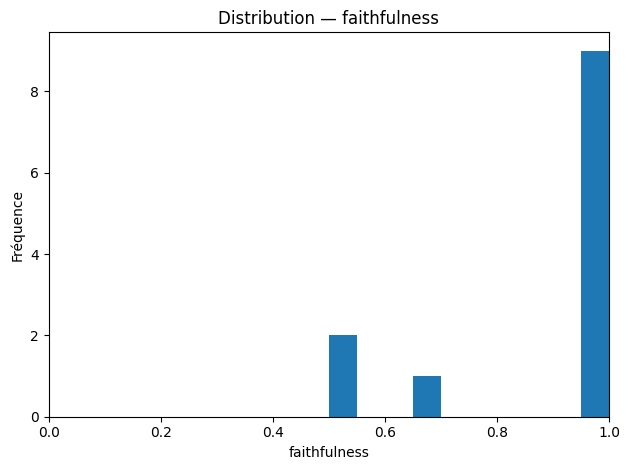

Saved: outputs/hist_answer_correctness.png


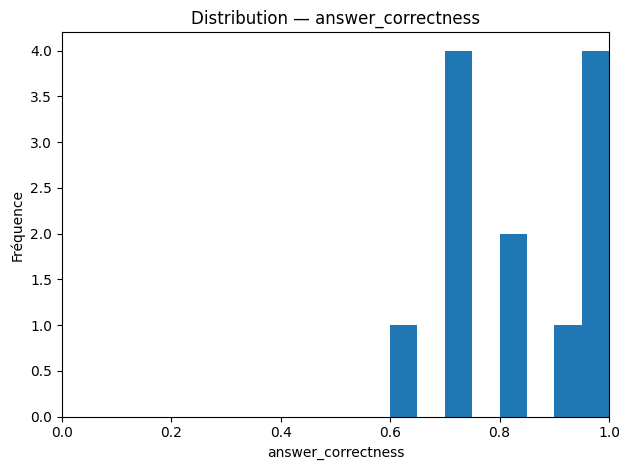

Saved: outputs/hist_context_precision.png


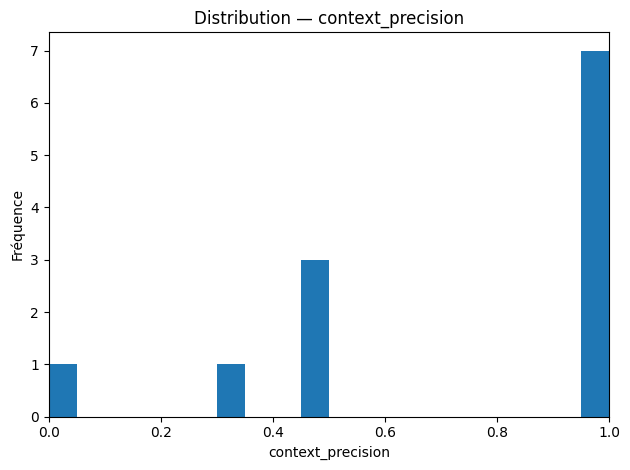

Saved: outputs/hist_context_recall.png


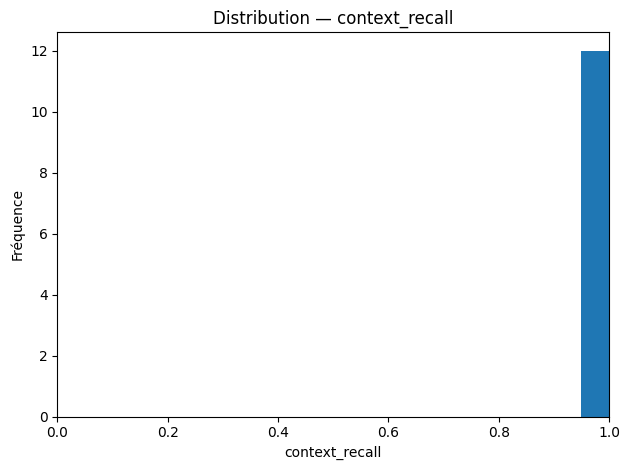

Saved: outputs/hist_answer_relevancy.png


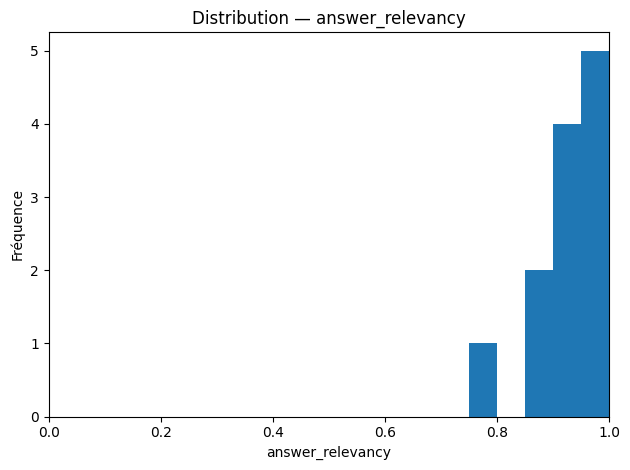

Saved: outputs/hist_doc_precision.png


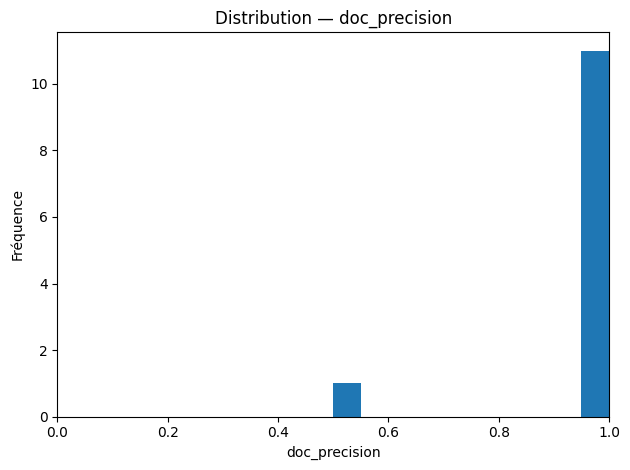

Saved: outputs/hist_doc_recall.png


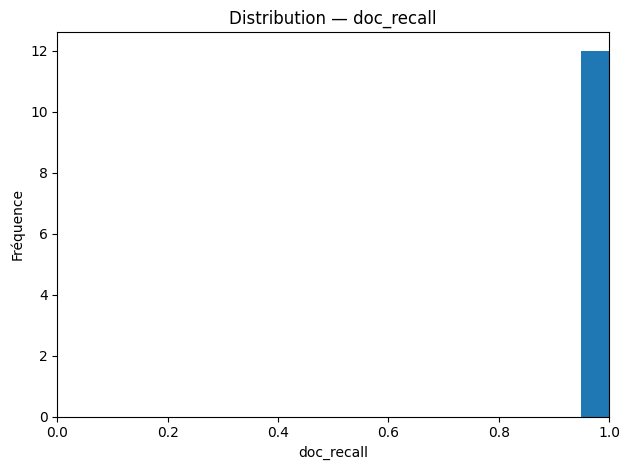

Saved: outputs/hist_doc_f1.png


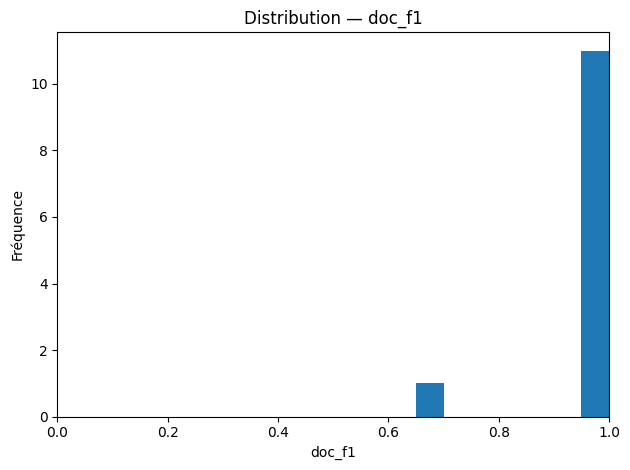

Saved: outputs/hist_doc_jaccard.png


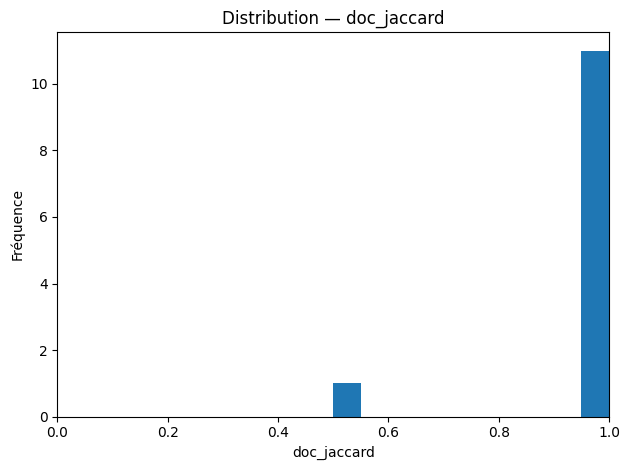

Saved: outputs/hist_context_coverage_jaccard.png


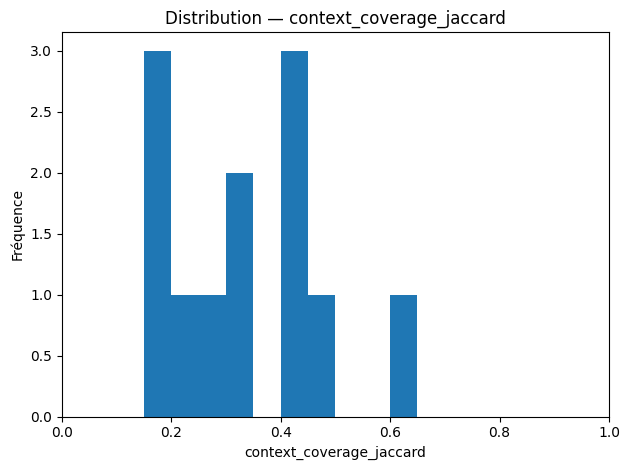

Saved: outputs/hist_answer_coverage_jaccard.png


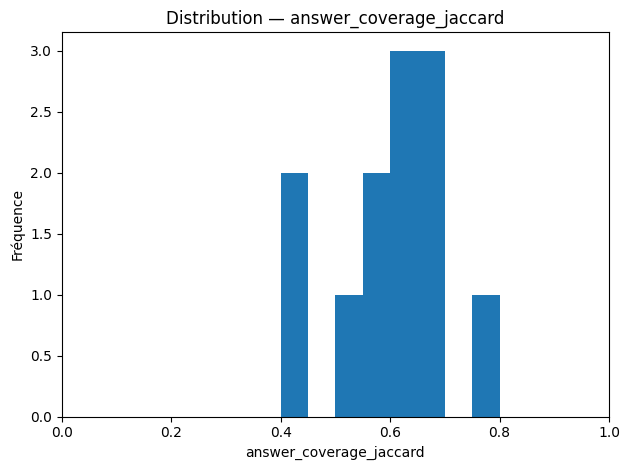

In [16]:

import matplotlib.pyplot as plt, numpy as np, os
BOUNDED01_COLS = [
    "faithfulness","answer_correctness","context_precision","context_recall",
    "response_relevancy","answer_relevancy",
    "doc_precision","doc_recall","doc_f1","doc_jaccard",
    "context_coverage_jaccard","answer_coverage_jaccard"
]
for col in BOUNDED01_COLS:
    if col in df_all.columns:
        plt.figure()
        bins = np.linspace(0, 1, 21)
        df_all[col].dropna().clip(0,1).plot(kind="hist", bins=bins, title=f"Distribution — {col}")
        plt.xlabel(col); plt.ylabel("Fréquence"); plt.xlim(0,1)
        plt.tight_layout()
        outp = os.path.join(OUTPUT_DIR, f"hist_{col}.png"); plt.savefig(outp); print("Saved:", outp); plt.show()


Axes fixes [0,1] pour toutes les métriques bornées (pas d’auto-scale).

Pics à 0 → manque systématique (ex. rappel nul). Pics à 1 → très bon.

Dispersion → instabilité / variabilité selon les cas.

## 11) Focus erreurs — Top‑K items les plus faibles

In [17]:

import pandas as pd
def topk_worst(col, k=15):
    if col not in df_all.columns: return pd.DataFrame()
    sub = df_all[["question","answer","ground_truth", col]].copy()
    return sub.sort_values(col, ascending=True).head(k)
print("### Pires 'answer_correctness'"); display(topk_worst("answer_correctness"))
print("\n### Pires 'faithfulness'"); display(topk_worst("faithfulness"))
rel_col = "response_relevancy" if "response_relevancy" in df_all.columns else ("answer_relevancy" if "answer_relevancy" in df_all.columns else None)
if rel_col: print(f"\n### Pires '{rel_col}'"); display(topk_worst(rel_col))
print("\n### Pires 'doc_jaccard' (écart attendu vs cité)"); display(topk_worst("doc_jaccard"))


### Pires 'answer_correctness'


,question,answer,ground_truth,answer_correctness
7,Qui dirige l'équipe Data Warehouse ?,Hélène Petit occupe le poste de Directrice Data Warehouse et gère l'équipe Data Warehouse.,Hélène Petit dirige l'équipe Data Warehouse.,0.621241
6,Quel framework a été confirmé pour le modèle principal ?,"TensorFlow a été confirmé comme framework pour le modèle principal du projet, avec Sophie Martin responsable de l'im...",TensorFlow a été confirmé comme framework pour le modèle principal.,0.741270
0,Qui est le chef de projet du Projet Néo ?,Marc Dubois est le chef de projet du Projet Néo selon les informations du cadrage.,Marc Dubois est le chef de projet du Projet Néo.,0.743916
4,Qui est le manager de Sophie Martin ?,Marc Dubois est le manager de Sophie Martin selon l'organigramme de l'équipe.,Marc Dubois est le manager de Sophie Martin.,0.745691
11,De quel projet stratégique fait partie le Projet Néo ?,Le Projet Néo s'inscrit dans le cadre de l'initiative stratégique 'Quantum Leap' comme composante clé.,Le Projet Néo est une composante clé de l'initiative stratégique 'Quantum Leap'.,0.747059
10,Quel risque a souligné David Chen concernant les données ?,"David Chen a identifié un risque majeur concernant la qualité des données historiques, nécessitant une synchronisati...",David Chen a souligné un risque concernant la qualité des données historiques.,0.834138
5,Quelle est la date limite pour le premier PoC de Sophie Martin ?,Sophie Martin doit livrer un premier PoC (Proof of Concept) pour le 1er Mars 2025 selon les décisions de la réunion ...,Sophie Martin doit livrer un premier PoC (Proof of Concept) pour le 1er Mars 2025.,0.846984
3,Quelles sont les compétences de David Chen ?,"David Chen, Data Scientist Principal, maîtrise Python, Scikit-learn, TensorFlow et le NLP (Natural Language Processi...","David Chen possède des compétences en Python, Scikit-learn, TensorFlow et NLP.",0.907657
1,Quel est l'objectif principal du Projet Néo ?,L'objectif du Projet Néo est de développer un nouvel algorithme de recommandation pour la plateforme e-commerce afin...,Le Projet Néo vise à développer un nouvel algorithme de recommandation pour notre plateforme e-commerce avec un obje...,0.993853
8,Quelle base de données est envisagée pour le projet ?,Neo4j est la base de données envisagée pour le projet en raison de sa capacité à modéliser efficacement les relation...,Neo4j est envisagé comme base de données pour sa capacité à modéliser les relations entre produits.,0.995709



### Pires 'faithfulness'


,question,answer,ground_truth,faithfulness
4,Qui est le manager de Sophie Martin ?,Marc Dubois est le manager de Sophie Martin selon l'organigramme de l'équipe.,Marc Dubois est le manager de Sophie Martin.,0.500000
10,Quel risque a souligné David Chen concernant les données ?,"David Chen a identifié un risque majeur concernant la qualité des données historiques, nécessitant une synchronisati...",David Chen a souligné un risque concernant la qualité des données historiques.,0.500000
5,Quelle est la date limite pour le premier PoC de Sophie Martin ?,Sophie Martin doit livrer un premier PoC (Proof of Concept) pour le 1er Mars 2025 selon les décisions de la réunion ...,Sophie Martin doit livrer un premier PoC (Proof of Concept) pour le 1er Mars 2025.,0.666667
0,Qui est le chef de projet du Projet Néo ?,Marc Dubois est le chef de projet du Projet Néo selon les informations du cadrage.,Marc Dubois est le chef de projet du Projet Néo.,1.000000
3,Quelles sont les compétences de David Chen ?,"David Chen, Data Scientist Principal, maîtrise Python, Scikit-learn, TensorFlow et le NLP (Natural Language Processi...","David Chen possède des compétences en Python, Scikit-learn, TensorFlow et NLP.",1.000000
2,Qui est le lead developer assigné au projet ?,Sophie Martin est désignée comme Lead Developer pour le Projet Néo.,Sophie Martin est le lead developer assigné au Projet Néo.,1.000000
6,Quel framework a été confirmé pour le modèle principal ?,"TensorFlow a été confirmé comme framework pour le modèle principal du projet, avec Sophie Martin responsable de l'im...",TensorFlow a été confirmé comme framework pour le modèle principal.,1.000000
1,Quel est l'objectif principal du Projet Néo ?,L'objectif du Projet Néo est de développer un nouvel algorithme de recommandation pour la plateforme e-commerce afin...,Le Projet Néo vise à développer un nouvel algorithme de recommandation pour notre plateforme e-commerce avec un obje...,1.000000
7,Qui dirige l'équipe Data Warehouse ?,Hélène Petit occupe le poste de Directrice Data Warehouse et gère l'équipe Data Warehouse.,Hélène Petit dirige l'équipe Data Warehouse.,1.000000
8,Quelle base de données est envisagée pour le projet ?,Neo4j est la base de données envisagée pour le projet en raison de sa capacité à modéliser efficacement les relation...,Neo4j est envisagé comme base de données pour sa capacité à modéliser les relations entre produits.,1.000000



### Pires 'answer_relevancy'


,question,answer,ground_truth,answer_relevancy
7,Qui dirige l'équipe Data Warehouse ?,Hélène Petit occupe le poste de Directrice Data Warehouse et gère l'équipe Data Warehouse.,Hélène Petit dirige l'équipe Data Warehouse.,0.765512
3,Quelles sont les compétences de David Chen ?,"David Chen, Data Scientist Principal, maîtrise Python, Scikit-learn, TensorFlow et le NLP (Natural Language Processi...","David Chen possède des compétences en Python, Scikit-learn, TensorFlow et NLP.",0.881353
8,Quelle base de données est envisagée pour le projet ?,Neo4j est la base de données envisagée pour le projet en raison de sa capacité à modéliser efficacement les relation...,Neo4j est envisagé comme base de données pour sa capacité à modéliser les relations entre produits.,0.882434
11,De quel projet stratégique fait partie le Projet Néo ?,Le Projet Néo s'inscrit dans le cadre de l'initiative stratégique 'Quantum Leap' comme composante clé.,Le Projet Néo est une composante clé de l'initiative stratégique 'Quantum Leap'.,0.900546
5,Quelle est la date limite pour le premier PoC de Sophie Martin ?,Sophie Martin doit livrer un premier PoC (Proof of Concept) pour le 1er Mars 2025 selon les décisions de la réunion ...,Sophie Martin doit livrer un premier PoC (Proof of Concept) pour le 1er Mars 2025.,0.926650
2,Qui est le lead developer assigné au projet ?,Sophie Martin est désignée comme Lead Developer pour le Projet Néo.,Sophie Martin est le lead developer assigné au Projet Néo.,0.930798
10,Quel risque a souligné David Chen concernant les données ?,"David Chen a identifié un risque majeur concernant la qualité des données historiques, nécessitant une synchronisati...",David Chen a souligné un risque concernant la qualité des données historiques.,0.942503
6,Quel framework a été confirmé pour le modèle principal ?,"TensorFlow a été confirmé comme framework pour le modèle principal du projet, avec Sophie Martin responsable de l'im...",TensorFlow a été confirmé comme framework pour le modèle principal.,0.967857
4,Qui est le manager de Sophie Martin ?,Marc Dubois est le manager de Sophie Martin selon l'organigramme de l'équipe.,Marc Dubois est le manager de Sophie Martin.,0.970598
1,Quel est l'objectif principal du Projet Néo ?,L'objectif du Projet Néo est de développer un nouvel algorithme de recommandation pour la plateforme e-commerce afin...,Le Projet Néo vise à développer un nouvel algorithme de recommandation pour notre plateforme e-commerce avec un obje...,0.985758



### Pires 'doc_jaccard' (écart attendu vs cité)


,question,answer,ground_truth,doc_jaccard
0,Qui est le chef de projet du Projet Néo ?,Marc Dubois est le chef de projet du Projet Néo selon les informations du cadrage.,Marc Dubois est le chef de projet du Projet Néo.,0.5
1,Quel est l'objectif principal du Projet Néo ?,L'objectif du Projet Néo est de développer un nouvel algorithme de recommandation pour la plateforme e-commerce afin...,Le Projet Néo vise à développer un nouvel algorithme de recommandation pour notre plateforme e-commerce avec un obje...,1.0
2,Qui est le lead developer assigné au projet ?,Sophie Martin est désignée comme Lead Developer pour le Projet Néo.,Sophie Martin est le lead developer assigné au Projet Néo.,1.0
3,Quelles sont les compétences de David Chen ?,"David Chen, Data Scientist Principal, maîtrise Python, Scikit-learn, TensorFlow et le NLP (Natural Language Processi...","David Chen possède des compétences en Python, Scikit-learn, TensorFlow et NLP.",1.0
4,Qui est le manager de Sophie Martin ?,Marc Dubois est le manager de Sophie Martin selon l'organigramme de l'équipe.,Marc Dubois est le manager de Sophie Martin.,1.0
5,Quelle est la date limite pour le premier PoC de Sophie Martin ?,Sophie Martin doit livrer un premier PoC (Proof of Concept) pour le 1er Mars 2025 selon les décisions de la réunion ...,Sophie Martin doit livrer un premier PoC (Proof of Concept) pour le 1er Mars 2025.,1.0
6,Quel framework a été confirmé pour le modèle principal ?,"TensorFlow a été confirmé comme framework pour le modèle principal du projet, avec Sophie Martin responsable de l'im...",TensorFlow a été confirmé comme framework pour le modèle principal.,1.0
7,Qui dirige l'équipe Data Warehouse ?,Hélène Petit occupe le poste de Directrice Data Warehouse et gère l'équipe Data Warehouse.,Hélène Petit dirige l'équipe Data Warehouse.,1.0
8,Quelle base de données est envisagée pour le projet ?,Neo4j est la base de données envisagée pour le projet en raison de sa capacité à modéliser efficacement les relation...,Neo4j est envisagé comme base de données pour sa capacité à modéliser les relations entre produits.,1.0
9,Quand est prévue la revue de projet avec Carole Lambert ?,La revue de projet avec Carole Lambert est programmée pour le 15 Mars 2025.,Une revue de projet est fixée avec Carole Lambert pour le 15 Mars 2025.,1.0


Cas pour déboguer : lisez question/answer/GT et comparez avec
n_contexts, *_coverage_jaccard, doc_*.

Idéal pour construire un jeu d’unit tests de non-régression.

## 12) Scatters — relations (axes 0–1 si métriques bornées)

In [ ]:

import matplotlib.pyplot as plt, os
BOUNDED01_COLS = set(["faithfulness","answer_correctness","context_precision","context_recall",
                      "response_relevancy","answer_relevancy",
                      "doc_precision","doc_recall","doc_f1","doc_jaccard",
                      "context_coverage_jaccard","answer_coverage_jaccard"])
def scatter_xy(x, y):
    if x in df_all.columns and y in df_all.columns:
        plt.figure(); plt.scatter(df_all[x], df_all[y])
        plt.xlabel(x); plt.ylabel(y); plt.title(f"{x} vs {y}")
        if x in BOUNDED01_COLS and y in BOUNDED01_COLS: plt.xlim(0,1); plt.ylim(0,1)
        plt.tight_layout(); outp = os.path.join(OUTPUT_DIR, f"scatter_{x}_vs_{y}.png"); plt.savefig(outp); print("Saved:", outp); plt.show()
scatter_xy("faithfulness", "answer_correctness")
if rel_col: scatter_xy(rel_col, "answer_correctness")
scatter_xy("context_precision", "context_recall")
scatter_xy("doc_jaccard", "answer_correctness")
scatter_xy("doc_recall", "answer_correctness")
scatter_xy("n_contexts", "answer_correctness")


Axes [0,1] si métriques bornées (cohérence visuelle).

Relations attendues :
context_precision ↑ et context_recall ↑ → answer_correctness ↑.
n_contexts trop élevé peut dégrader la précision (bruit).

## 13) Corrélations — Matrice (Pearson, NaN masqués, échelle −1..1)

In [ ]:

import numpy as np, pandas as pd, matplotlib.pyplot as plt, os
target_cols = ["faithfulness","answer_correctness",
               "response_relevancy" if "response_relevancy" in df_all.columns else "answer_relevancy",
               "context_precision","context_recall",
               "doc_precision","doc_recall","doc_f1","doc_jaccard",
               "context_coverage_jaccard","answer_coverage_jaccard",
               "n_contexts","avg_context_len","total_context_len",
               "answer_len","question_len","gt_len"]
present_cols = [c for c in target_cols if c in df_all.columns]
df_num = df_all[present_cols].apply(pd.to_numeric, errors="coerce")
report = []
for c in present_cols:
    s = df_num[c].dropna()
    if len(s) == 0: report.append(f"{c}: aucune valeur numérique (NaN)")
    elif s.nunique() <= 1: report.append(f"{c}: constante (corrélation indéfinie)")
if report:
    print("⚠️ Colonnes potentiellement non corrélables:"); [print(" -", r) for r in report]
corr = df_num.corr().reindex(index=present_cols, columns=present_cols)
masked = np.ma.masked_invalid(corr.values)
plt.figure(); im = plt.imshow(masked, aspect='auto', vmin=-1, vmax=1)
plt.xticks(range(len(present_cols)), present_cols, rotation=90); plt.yticks(range(len(present_cols)), present_cols)
plt.colorbar(im, label="corrélation (Pearson)"); plt.title("Matrice de corrélations (NaN masqués)")
plt.tight_layout(); outp = os.path.join(OUTPUT_DIR, "corr_matrix.png"); plt.savefig(outp); print("Saved:", outp); plt.show()


Cases blanches = corrélation indéfinie (colonne constante ou trop de NaN).

Regardez answer_correctness vs context_* : corr faible → revoir retrieval/rerank/chunking.

Corrélations fortes négatives/positives indiquent des leviers clairs.

## 14) Effet du nombre de contextes — agrégations par *bins*

In [ ]:

import pandas as pd, matplotlib.pyplot as plt, os
rel_col = "response_relevancy" if "response_relevancy" in df_all.columns else ("answer_relevancy" if "answer_relevancy" in df_all.columns else None)
def agg_by_bins(col, bins=(0,1,2,3,4,6,10,999)):
    if col not in df_all.columns: return pd.DataFrame()
    b = pd.cut(df_all[col], bins=bins, right=True)
    cols = ["faithfulness","answer_correctness","context_precision","context_recall","doc_recall","doc_jaccard"]
    if rel_col and rel_col in df_all.columns: cols.append(rel_col)
    agg = df_all.groupby(b)[cols].mean(numeric_only=True).reset_index()
    return agg
agg_ctx = agg_by_bins("n_contexts"); display(agg_ctx)
for c in [c for c in agg_ctx.columns if c != "n_contexts"]:
    plt.figure(); x = agg_ctx.iloc[:,0].astype(str); y = agg_ctx[c]
    plt.bar(x, y); 
    if c in {"faithfulness","answer_correctness","context_precision","context_recall","doc_recall","doc_jaccard","response_relevancy","answer_relevancy"}: plt.ylim(0,1)
    plt.xticks(rotation=30, ha="right"); plt.ylabel(c); plt.title(f"{c} moyen par bin de n_contexts")
    plt.tight_layout(); outp = os.path.join(OUTPUT_DIR, f"bar_{c}_by_ncontexts_bins.png"); plt.savefig(outp); print("Saved:", outp); plt.show()


Compare les scores moyens par tranches de n_contexts.

Schéma fréquent en U :
trop peu → manque de rappel ; trop → bruit.
À optimiser : top-k, hybride (BM25+vecteur), reranking.

## 15) Analyse par document/source (`sharepoint_document`)

In [ ]:

import pandas as pd, matplotlib.pyplot as plt, os
src_col = "sharepoint_document" if "sharepoint_document" in raw_df.columns else None
rel_col = "response_relevancy" if "response_relevancy" in df_all.columns else ("answer_relevancy" if "answer_relevancy" in df_all.columns else None)
if src_col:
    metric_cols = ["faithfulness","answer_correctness","context_precision","context_recall","doc_recall","doc_precision","doc_f1","doc_jaccard"]
    if rel_col and rel_col in df_all.columns: metric_cols.insert(2, rel_col)
    per_src = pd.concat([raw_df[[src_col]], df_all[metric_cols]], axis=1)
    agg_src = per_src.groupby(src_col).mean(numeric_only=True).sort_values("answer_correctness", ascending=False)
    display(agg_src.head(10))
    topk = agg_src.head(10)
    if len(topk) > 0:
        plt.figure(); plt.bar(topk.index.astype(str), topk["answer_correctness"]); plt.ylim(0,1)
        plt.xticks(rotation=45, ha="right"); plt.ylabel("answer_correctness"); plt.title("Top documents — answer_correctness moyen")
        plt.tight_layout(); outp = os.path.join(OUTPUT_DIR, "bar_top_docs_answer_correctness.png"); plt.savefig(outp); print("Saved:", outp); plt.show()
else:
    print("Aucune colonne 'sharepoint_document' détectée.")


Identifiez les sources faibles (OCR, tableaux, colonnes, headers/footers).

Priorisez le préprocessing PDF, l’OCR, et la réindexation sur ces sources.

Utilisez les moyennes par source pour piloter les correctifs.

## 16) Recommandations automatiques

In [ ]:

import os
reco = []; add = lambda msg: (print("•", msg), reco.append("• " + msg))
mean = df_all.mean(numeric_only=True).to_dict(); m = lambda k: mean.get(k, None)
if (m("faithfulness") or 0) < 0.6: add("Fidélité basse : citations verbatim, température 0, format contraint.")
if (m("answer_correctness") or 0) < 0.6 and (m("context_recall") or 0) >= 0.6: add("Incorrect malgré rappel : prompt d'extraction stricte + self-check.")
if (m("context_recall") or 0) < 0.6: add("Rappel faible : top-k, hybride BM25+vecteur, chunking, préprocessing PDF.")
if (m("context_precision") or 0) < 0.6: add("Précision faible : reranker cross-encoder, réduire top-k, filtres métadonnées.")
if (m("doc_jaccard") or 0) < 0.6: add("Écart entre docs attendus et cités : normaliser doc_id (`|||` OK), améliorer extraction citations, enrichir métadonnées.")
with open(os.path.join(OUTPUT_DIR, "auto_recommendations.txt"), "w", encoding="utf-8") as f:
    f.write("Recommandations automatiques\n\n"); [f.write(r+"\n") for r in reco]
print("Recommandations ->", os.path.join(OUTPUT_DIR, "auto_recommendations.txt"))


Générées depuis les moyennes et quelques corrélations simples.

Servez-vous de cette liste comme backlog : retrieval (recall/precision), rerank, chunking, embeddings FR/domaine, prompts d’extraction.

## 17) Plan d’expériences (A/B & grille)

In [ ]:

import json, os
param_grid = {
    "preprocess": [
        {"ocr": False, "clean_headers": True, "normalize_ws": True},
        {"ocr": True,  "clean_headers": True, "normalize_ws": True},
    ],
    "embedding": [
        {"provider":"openai","model":"text-embedding-3-large"},
        {"provider":"openai","model":"text-embedding-3-small"},
        {"provider":"nomic","model":"nomic-embed-text"},
    ],
    "chunking": [
        {"method":"fixed","size":512,"overlap":64},
        {"method":"fixed","size":800,"overlap":100},
        {"method":"semantic","size":"auto","overlap":64},
    ],
    "retrieval": [
        {"type":"vector","top_k":8},
        {"type":"hybrid","bm25_weight":0.4,"top_k":8},
        {"type":"hybrid","bm25_weight":0.6,"top_k":12},
    ],
    "rerank": [
        {"enabled": False},
        {"enabled": True, "model":"cross-encoder/ms-marco-MiniLM-L-6-v2", "top_k":5},
    ],
}
with open(os.path.join(OUTPUT_DIR, "experiment_plan.json"), "w", encoding="utf-8") as f:
    json.dump(param_grid, f, ensure_ascii=False, indent=2)
print("Plan d'expériences ->", os.path.join(OUTPUT_DIR, "experiment_plan.json"))


Couvrir les axes : préprocessing PDF, embedding, chunking, recherche (vector/hybride), reranking.

Exécuter 1 variable à la fois quand c’est possible ; consigner paramètres + scores.

## 18) Dashboard comparatif **multi‑runs** (incl. `doc_jaccard`)

In [ ]:

import os, glob, pandas as pd, numpy as np, matplotlib.pyplot as plt
auto_paths = sorted(glob.glob(os.path.join(OUTPUT_DIR, "**", "ragas_results_enriched.csv"), recursive=True))
RUN_PATHS = []  # Ajoutez des chemins explicites si besoin
all_paths = RUN_PATHS if RUN_PATHS else auto_paths
if not all_paths:
    print("⚠️ Aucun run trouvé. Placez des fichiers 'ragas_results_enriched.csv' dans des sous-dossiers de 'outputs/'.")
else:
    print("Runs détectés:"); [print(" -", p) for p in all_paths]

def unify_cols(df):
    if "response_relevancy" in df.columns: df["relevancy"] = df["response_relevancy"]
    elif "answer_relevancy" in df.columns: df["relevancy"] = df["answer_relevancy"]
    for c in ["faithfulness","answer_correctness","relevancy","context_precision","context_recall",
              "doc_precision","doc_recall","doc_f1","doc_jaccard",
              "context_coverage_jaccard","answer_coverage_jaccard"]:
        if c in df.columns: df[c] = pd.to_numeric(df[c], errors="coerce").clip(0,1)
    return df

runs = []
for p in all_paths:
    try:
        df_run = pd.read_csv(p); df_run = unify_cols(df_run)
        run_id = os.path.basename(os.path.dirname(p)) or "run"; runs.append((run_id, df_run))
    except Exception as e:
        print("Skip", p, "->", e)

metrics = ["faithfulness","answer_correctness","relevancy","context_precision","context_recall","doc_precision","doc_recall","doc_f1","doc_jaccard"]
summary_rows = []
for run_id, df_run in runs:
    row = {"run": run_id}
    for m in metrics:
        if m in df_run.columns: row[m] = float(np.nanmean(df_run[m]))
    summary_rows.append(row)
df_summary = pd.DataFrame(summary_rows).set_index("run").sort_index()
display(df_summary)
df_summary.to_csv(os.path.join(OUTPUT_DIR, "multirun_summary.csv"), encoding="utf-8")

# Barres (0–1)
for m in metrics:
    if m in df_summary.columns:
        plt.figure(); df_summary[m].plot(kind="bar", title=f"Moyenne — {m}")
        plt.ylim(0,1); plt.ylabel(m); plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR, f"multirun_bar_{m}.png")); plt.show()

# Boxplots (0–1)
for m in metrics:
    data, labels = [], []
    for run_id, df_run in runs:
        if m in df_run.columns:
            data.append(df_run[m].dropna().clip(0,1).values); labels.append(run_id)
    if data:
        plt.figure(); plt.boxplot(data, labels=labels, showmeans=True)
        plt.ylim(0,1); plt.title(f"Distribution — {m}"); plt.ylabel(m); plt.xticks(rotation=30, ha="right"); plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR, f"multirun_box_{m}.png")); plt.show()

# Δ vs baseline (premier run)
if len(runs) >= 2:
    base_id, base_df = runs[0]
    base_means = {m: float(np.nanmean(base_df[m])) for m in metrics if m in base_df.columns}
    for m in base_means:
        xs, ys = [], []
        for run_id, df_run in runs[1:]:
            if m in df_run.columns:
                xs.append(run_id); ys.append(float(np.nanmean(df_run[m])) - base_means[m])
        if xs:
            plt.figure(); plt.bar(xs, ys); plt.axhline(0, linestyle="--")
            plt.ylabel(f"Δ {m} (vs {base_id})"); plt.title(f"Delta moyenne — {m}")
            plt.xticks(rotation=30, ha="right"); plt.tight_layout()
            plt.savefig(os.path.join(OUTPUT_DIR, f"multirun_delta_{m}_vs_{base_id}.png")); plt.show()


Barres = moyennes par run ; Boxplots = dispersion/stabilité ; Δ vs baseline = gain net.

Cherchez un run qui améliore answer_correctness sans dégrader faithfulness/relevancy/context_*.

Utilisez-le pour des revues régulières (hebdo) de l’amélioration du RAG.